## Imports

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import io

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and process dataset

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 5s 0us/step


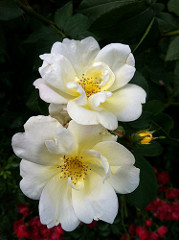

In [3]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


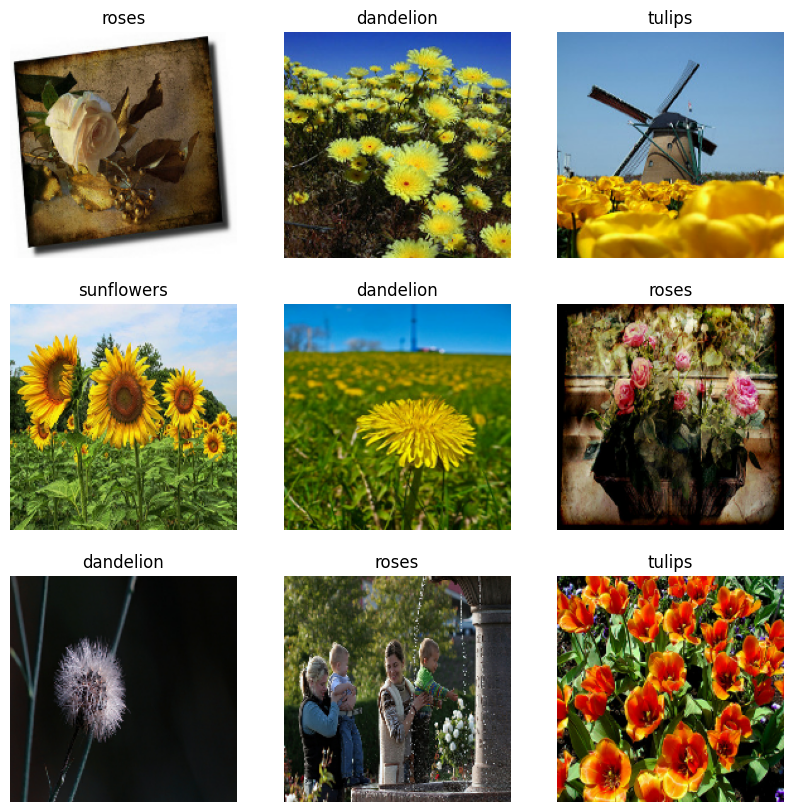

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
num_classes = len(class_names)

In [15]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Define, Compile, and Train Model

In [16]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 44s 463ms/step - loss: 1.4037 - accuracy: 0.3982 - val_loss: 1.1538 - val_accuracy: 0.5000
Epoch 2/10
92/92 [==============================] - 42s 460ms/step - loss: 1.1061 - accuracy: 0.5317 - val_loss: 1.0378 - val_accuracy: 0.5886
Epoch 3/10
92/92 [==============================] - 44s 475ms/step - loss: 1.0153 - accuracy: 0.5964 - val_loss: 0.9816 - val_accuracy: 0.6267
Epoch 4/10
92/92 [==============================] - 43s 463ms/step - loss: 0.9239 - accuracy: 0.6444 - val_loss: 0.9744 - val_accuracy: 0.6104
Epoch 5/10
92/92 [==============================] - 42s 459ms/step - loss: 0.8735 - accuracy: 0.6580 - val_loss: 0.8515 - val_accuracy: 0.6635
Epoch 6/10
92/92 [==============================] - 42s 459ms/step - loss: 0.8039 - accuracy: 0.6846 - val_loss: 0.9072 - val_accuracy: 0.6540
Epoch 7/10
92/92 [==============================] - 42s 457ms/step - loss: 0.7498 - accuracy: 0.7122 - val_loss: 0.9779 - val_accuracy: 0.5995

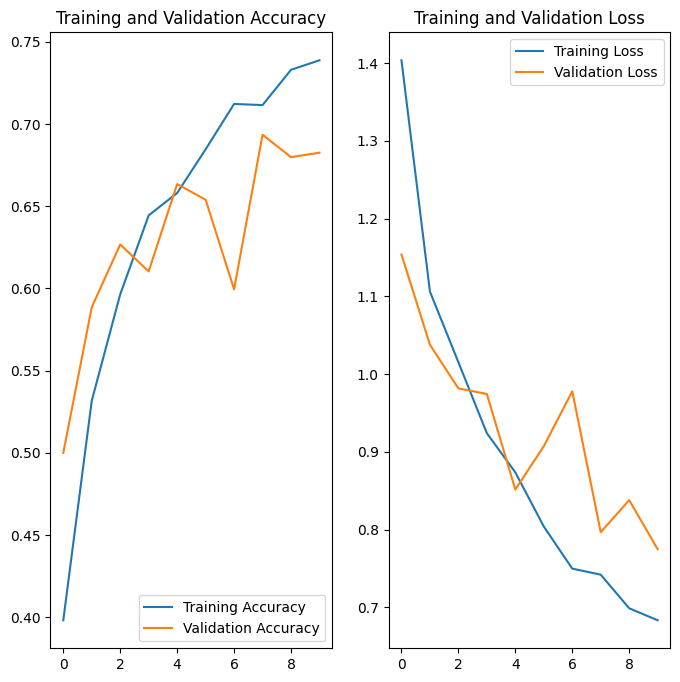

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict & Save Model 

In [20]:
# predict on new data
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 130ms/step
This image most likely belongs to sunflowers with a 61.25 percent confidence.


In [22]:
# save model

# keras
model.save("model")

INFO:tensorflow:Assets written to: tf-keras-img-classification\assets


INFO:tensorflow:Assets written to: tf-keras-img-classification\assets


In [23]:
# try to load model 
loaded_model = tf.keras.saving.load_model("model")

In [53]:
# img = tf.keras.utils.load_img(
#     sunflower_path, target_size=(img_height, img_width)
# )

img = tf.keras.utils.load_img(
    io.BytesIO(open(sunflower_path, "rb").read()), target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = loaded_model.predict(img_array)
scores = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(scores)], 100 * np.max(scores))
)

1/1 [==============================] - 0s 28ms/step
This image most likely belongs to sunflowers with a 61.25 percent confidence.


In [71]:
indices = np.argsort(scores)[::-1]
inference_result = {
    "classPredictions": [
        {"class": class_names[index], "score": round(scores[index].numpy().item(),4)} for index in indices
    ]
}

In [72]:
inference_result

{'classPredictions': [{'class': 'sunflowers', 'score': 0.6125},
  {'class': 'tulips', 'score': 0.2476},
  {'class': 'roses', 'score': 0.138},
  {'class': 'daisy', 'score': 0.0014},
  {'class': 'dandelion', 'score': 0.0006}]}